## MULTI DAPI VAE in PYRO

### IMPORT NECESSARY MODULES

In [1]:
#%%bash
#ls

In [2]:
import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1" #for debugging, it decrease performance dramatically

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pyplot as mp

from LOW_LEVEL_UTILITIES.utilities import show_batch, save_obj, load_obj, dataset_in_memory, check_datasets
from LOW_LEVEL_UTILITIES.utilities import train_one_epoch, evaluate_one_epoch, test_model, linear_decay_p_factor
from simulation_dictionary import SimulationDictionary 
from VAE.vae_model import Compositional_VAE

import numpy as np
import torch
import pyro
from pyro.infer import SVI, TraceEnum_ELBO, TraceGraph_ELBO, config_enumerate, JitTraceEnum_ELBO 
from pyro.optim import Adam, Adamax, SGD

# Set up pyro environment
pyro.clear_param_store()
pyro.set_rng_seed(0)

# Get the data

In [4]:
#disk_data_dir = "/home/ldalessi/DATA/MULTI_DISK/"
#real_data_dir = "/home/ldalessi/DATA/DAPI_ONLY_v3/"
#mMNIST_data_dir = "/home/ldalessi/DATA/MULTI_MNIST/"
mMNIST_data_dir = "/home/jupyter/REPOS/spacetx-research/DATA/MULTI_MNIST/"
fashion_data_dir = "/home/jupyter/REPOS/spacetx-research/DATA/MULTI_FashionMNIST/"

train_dataset = dataset_in_memory(fashion_data_dir,"multi_Fashionmnist_train_large_hard",use_cuda=torch.cuda.is_available())
test_dataset  = dataset_in_memory(fashion_data_dir,"multi_Fashionmnist_test_large_hard",use_cuda=torch.cuda.is_available())

#train_dataset = dataset_in_memory(mMNIST_data_dir,"multi_mnist_train_large",use_cuda=torch.cuda.is_available())
#test_dataset  = dataset_in_memory(mMNIST_data_dir,"multi_mnist_test_large",use_cuda=torch.cuda.is_available())

#train_dataset = dataset_in_memory(disk_data_dir,"multi_disk_train_v1",use_cuda=torch.cuda.is_available())
#test_dataset  = dataset_in_memory(disk_data_dir,"multi_disk_test_v1",use_cuda=torch.cuda.is_available())

#train_dataset = dataset_in_memory(disk_data_dir,"multi_disk_train_no_bg",use_cuda=torch.cuda.is_available())
#test_dataset  = dataset_in_memory(disk_data_dir,"multi_disk_test_no_bg",use_cuda=torch.cuda.is_available())

#train_dataset = dataset_in_memory(real_data_dir,"DAPI_dataset_train",use_cuda=torch.cuda.is_available())
#test_dataset  = dataset_in_memory(real_data_dir,"DAPI_dataset_test",use_cuda=torch.cuda.is_available())

#train_dataset = dataset_in_memory(mMNIST_data_dir,"multi_mnist_train_large",use_cuda=torch.cuda.is_available())
#test_dataset  = dataset_in_memory(mMNIST_data_dir,"multi_mnist_test_large",use_cuda=torch.cuda.is_available())

#train_dataset = dataset_in_memory(mMNIST_data_dir,"multi_mnist_train_no_bg",use_cuda=torch.cuda.is_available())
#test_dataset  = dataset_in_memory(mMNIST_data_dir,"multi_mnist_test_no_bg",use_cuda=torch.cuda.is_available())

Dataset lenght: 60000
imgs.shape torch.Size([8, 1, 80, 80])
type(imgs) <class 'torch.Tensor'>
imgs.device cuda:0
torch.max(imgs) tensor(1., device='cuda:0')
torch.min(imgs) tensor(0., device='cuda:0')


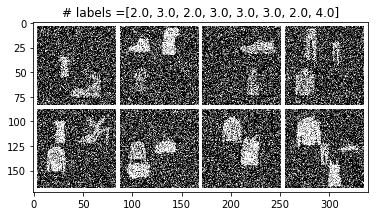

In [5]:
check_datasets(train_dataset)

Dataset lenght: 1000
imgs.shape torch.Size([8, 1, 80, 80])
type(imgs) <class 'torch.Tensor'>
imgs.device cuda:0
torch.max(imgs) tensor(1., device='cuda:0')
torch.min(imgs) tensor(0., device='cuda:0')


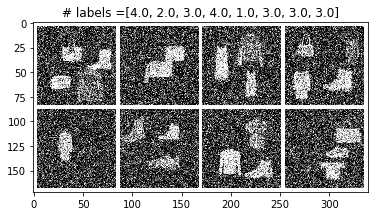

In [6]:
check_datasets(test_dataset)

In [9]:
imgs_in, labels = train_dataset.load(128)
print(labels[0])
show_batch(imgs_in[:1])

In [10]:
b = plt.hist(imgs_in.view(-1).cpu().numpy(), bins=100, range=(0,1),density=True)
plt.title("Empirical PDF")
plt.xlabel("pixel intensity")

In [7]:
#size=15
#r = test_dataset.analyze_brightness_distribution(size=size,stride=3)
#a = plt.hist(r.view(-1), bins=100, range=(0,1),density=True)
#plt.title("Empirical PDF")
#plt.xlabel("Average intensity in box of size "+str(size))

In [8]:
#size=35
#r = test_dataset.analyze_brightness_distribution(size=size,stride=3)
#a = plt.hist(r.view(-1), bins=100, range=(0,1),density=True)
#plt.title("Empirical PDF")
#plt.xlabel("Average intensity in box of size "+str(size))

# Generate the names

In [11]:
write_dir  = '/home/jupyter/REPOS/spacetx-research/ARCHIVE/'
#write_dir  = '/home/ldalessi/buckets/VAE-ARCHIVE/'

descriptor        = "FASHION_unit_cauchy_t4_v3"
#descriptor        = "MNIST_unit_cauchy_t4_v4"
#descriptor        = "DISK_v4"
#descriptor        = "DISK_speed"
name_vae          = descriptor+"_vae"
name_history      = descriptor+"_hystory"
name_hyper_params = descriptor+"_hyper_params"
epoch_restart     = 100 
from_scratch = True


if(from_scratch):
    epoch_restart     = -1
    hyper_params=SimulationDictionary()
    hyper_params.check_consistency()
    print(hyper_params)
    
    min_loss = 99999999
    history_dict = {
        "train_loss" : [],
        "test_loss" : [],
        "fg_mu" : [],
        "bg_mu" : [],
        "fg_sigma" : [],
        "bg_sigma" : [],
        "normal_sigma" : [],
        "std_bx_dimfull" : [],
        "std_by_dimfull" : [],
        "std_bw_dimfull" : [],
        "std_bh_dimfull" : []
        }
    
    vae = Compositional_VAE(hyper_params)
    vae.reset()
    
else:
    hyper_params = load_obj(write_dir,name_hyper_params+"_"+str(epoch_restart))
    hyper_params.check_consistency()
    print(hyper_params)
    history_dict = load_obj(write_dir,name_history+"_"+str(epoch_restart))
    min_loss = min(history_dict["test_loss"])
    vae = Compositional_VAE.load(hyper_params,write_dir,name_vae+"_"+str(epoch_restart))

save_obj(hyper_params,write_dir,name_hyper_params+"_write_test")

{'REGULARIZATION.lambda_tot_var_mask': 0.0, 'PRIOR.max_object_size': 35, 'REGULARIZATION.lambda_small_box_size': 1.0, 'UNET.N_max_pool': 4, 'SD.width': 28, 'IMG.ch_in_description': ['DAPI'], 'REGULARIZATION.LOSS_ZWHAT': 10.0, 'NMS.overlap_threshold': 0.2, 'PRIOR.expected_object_size': 20, 'UNET.N_up_conv': 2, 'ZWHAT.dim': 50, 'use_cuda': True, 'REGULARIZATION.lambda_big_mask_volume': 1.0, 'SD.dim_h1': -1, 'REGULARIZATION.LOSS_ZMASK': 1.0, 'PRIOR.n_max_objects': 6, 'NMS.p_threshold': 0.0, 'IMG.size_raw_image': 80, 'SD.dim_h2': -1, 'ZMASK.dim': 50, 'REGULARIZATION.p_corr_factor': 0.0, 'UNET.CH_after_first_two_conv': 32, 'UNET.N_prediction_maps': 1, 'PRIOR.min_object_size': 15, 'REGULARIZATION.lambda_overlap': 1.0}
reset ->  Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
reset ->  BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
reset ->  Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
reset ->  BatchNorm2d(32, eps=1e-05, momentum

In [ ]:
img_with_grid = vae.inference.unet.show_grid(test_img)
vae.inference.unet.describe_receptive_field(test_img)
print(img_with_grid .shape)
show_batch(img_with_grid [0])

In [12]:
#putative_imgs,putative_masks,background,c = vae.model()
#print("putative_imgs.shape",putative_imgs.shape)
#print("putative_masks.shape",putative_masks.shape)
#print("background.shape",background.shape)
#print("c.shape",c.shape)
#print("max(putative_imgs)",torch.max(putative_imgs))

In [13]:
#show_batch(background)

In [14]:
#show_batch(putative_imgs[0])

In [15]:
#show_batch(putative_masks[0])
#print(torch.min(putative_masks),torch.max(putative_masks))

In [16]:
#imgs_prior = vae.generate_synthetic_data(N=2)
#show_batch(imgs_prior[:8,:1,:,:])
#print("imgs_prior.shape",imgs_prior.shape)
#print("type(imgs_prior)",type(imgs_prior))
#print("imgs_prior.device",imgs_prior.device)
#print("torch.max(imgs_prior)",torch.max(imgs_prior))
#print("torch.min(imgs_prior)",torch.min(imgs_prior))

In [17]:
#putative_imgs,putative_masks,background,c = vae.model(imgs_prior.cuda())
##putative_imgs,pixel_weights,background,c = vae.model(imgs_prior)
#
#print("putative_imgs.shape",putative_imgs.shape)
#print("putative_masks.shape",putative_masks.shape)
#print("background.shape",background.shape)
#print("c.shape",c.shape)

In [18]:
#rec_img,z_where,putative_imgs,putative_masks,logp,reg = vae.reconstruct_img(imgs_prior,True)
#
#print("rec_img.shape",rec_img.shape)
#print("min, max of rec_img)",torch.min(rec_img),torch.max(rec_img))
#print("putative_imgs.shape",putative_imgs.shape)
#print("putative_masks.shape",putative_masks.shape)
#print("logp.logp_off.shape",logp.logp_off.shape)
#print("logp.logp_on_cauchy.shape",logp.logp_on_cauchy.shape)
#print("logp.logp_on_normal.shape",logp.logp_on_normal.shape)
#print("reg.small_box_size.shape",reg.small_box_size.shape)
#print("reg.big_mask_volume.shape",reg.big_mask_volume.shape)
#print("reg.tot_var_mask.shape",reg.tot_var_mask.shape)
#print("reg.overlap_mask.shape",reg.overlap_mask.shape)
#show_batch(rec_img[:8,:,:,:])

### Debug model and guide

In [19]:
#print("TEST SAMPLE")
#test_model(vae.model, 
#           vae.guide, TraceGraph_ELBO())
#
#print("TEST PARALLEL ENUM")
#test_model(vae.model, 
#           config_enumerate(vae.guide, "parallel"), 
#           TraceEnum_ELBO(max_plate_nesting=2))

## Global parameters

In [20]:
TEST_FREQUENCY = 5
WRITE_FREQUENCY = 5
smoke_test= False
if(smoke_test):
    pyro.enable_validation(False)
    pyro.distributions.enable_validation(True)
    NUM_EPOCHS = 6 
else:
    pyro.enable_validation(False)
    pyro.distributions.enable_validation(False)
    NUM_EPOCHS = 101
    
# batch size
batch_size = 256
decay_lenght_scale = 40

# setup the optimizer
#optimizer = Adamax(adam_args)
adam_args = {"lr": 1.0e-3} # pyro.tutorail has 1E-4 with Adam. I have used Adamax and 1E-3 for a while
optimizer = Adam(adam_args)

svi = SVI(vae.model, config_enumerate(vae.guide, "parallel"), optimizer, loss=TraceEnum_ELBO(max_plate_nesting=2))



# Actual train loop

In [ ]:
# training loop
for delta_epoch in range(1,NUM_EPOCHS+1):
    epoch = delta_epoch+epoch_restart
    vae.train()     
    vae.p_corr_factor = linear_decay_p_factor(epoch,decay_lenght_scale)
    print("epoch,vae.p_corr_factor",epoch,vae.p_corr_factor)
    loss = train_one_epoch(svi, train_dataset, epoch, batch_size, verbose=(delta_epoch==1))
    print("[epoch %03d] train loss: %.4f" % (epoch, loss))
                
    history_dict["train_loss"].append(loss)
    try:
        history_dict["fg_mu"].append(pyro.param("fg_mu").item())
        history_dict["bg_mu"].append(pyro.param("bg_mu").item())
        history_dict["fg_sigma"].append(pyro.param("fg_sigma").item())
        history_dict["bg_sigma"].append(pyro.param("bg_sigma").item())
        history_dict["normal_sigma"].append(pyro.param("normal_sigma").item())
        history_dict["std_bx_dimfull"].append(pyro.param("std_bx_dimfull").item())
        history_dict["std_by_dimfull"].append(pyro.param("std_by_dimfull").item())
        history_dict["std_bw_dimfull"].append(pyro.param("std_bw_dimfull").item())
        history_dict["std_bh_dimfull"].append(pyro.param("std_bh_dimfull").item())
    except:
        pass
            
    if(epoch % TEST_FREQUENCY == 0):
        vae.eval()
        loss = evaluate_one_epoch(svi, test_dataset, epoch, batch_size, verbose=(delta_epoch==1))        
        history_dict["test_loss"].append(loss)
            
        if(loss < min_loss):
            min_loss = loss
            print("[epoch %03d] test  loss: %.4f --New Record--" % (epoch, loss)) 
        else:
            print("[epoch %03d] test  loss: %.4f " % (epoch, loss))
                
        if((loss == min_loss) or ((epoch % WRITE_FREQUENCY) == 0)):   
            # Save on disk
            vae.save_everything(write_dir,name_vae+"_"+str(epoch))
            save_obj(history_dict,write_dir,name_history+"_"+str(epoch))
            save_obj(hyper_params,write_dir,name_hyper_params+"_"+str(epoch))

epoch,vae.p_corr_factor 0 0.5
i=   0 train_loss=1974849.50000
i=   1 train_loss=871241.31250
i=   2 train_loss=-389017.96875
i=   3 train_loss=-706088.25000
i=   4 train_loss=-946286.87500
i=   5 train_loss=-1480436.50000
i=   6 train_loss=-1491074.50000
i=   7 train_loss=-1337089.62500
i=   8 train_loss=-1604067.37500
i=   9 train_loss=-1636649.50000
i=  10 train_loss=-1740993.87500
i=  11 train_loss=-1740265.50000
i=  12 train_loss=-1749329.50000
i=  13 train_loss=-1514689.50000
i=  14 train_loss=-1642461.00000
i=  15 train_loss=-1919104.37500
i=  16 train_loss=-1926749.75000
i=  17 train_loss=-1763964.00000
i=  18 train_loss=-1774590.87500
i=  19 train_loss=-1830282.50000
i=  20 train_loss=-1756438.75000
i=  21 train_loss=-1766668.62500
i=  22 train_loss=-1835955.50000
i=  23 train_loss=-1740851.12500
i=  24 train_loss=-1846776.87500
i=  25 train_loss=-1938095.12500
i=  26 train_loss=-1888092.25000
i=  27 train_loss=-1722784.50000
i=  28 train_loss=-1863579.00000
i=  29 train_loss=-

# Check the results

In [ ]:
print(history_dict["train_loss"][-5:])
print(history_dict["test_loss"][-5:])
print(history_dict["bg_mu"][-5:])
print(history_dict["fg_mu"][-5:])
print(history_dict["bg_sigma"][-5:])
print(history_dict["fg_sigma"][-5:])
print(history_dict["normal_sigma"][-5:])
print(history_dict["std_bx_dimfull"][-5:])
print(history_dict["std_by_dimfull"][-5:])
print(history_dict["std_bw_dimfull"][-5:])
print(history_dict["std_bh_dimfull"][-5:])

In [ ]:
#plt.yscale('log')
y_shift=0
x_shift=0
plt.plot(np.arange(x_shift, x_shift+len(history_dict["train_loss"])), np.array(history_dict["train_loss"])+y_shift)
plt.plot(np.arange(x_shift, x_shift+len(history_dict["train_loss"]), TEST_FREQUENCY), np.array(history_dict["test_loss"])+y_shift, '.--')
plt.xlabel('epoch')
plt.ylabel('LOSS = - ELBO')
plt.title('Training procedure')
#plt.ylim(ymin = -10000, ymax=-4000)
plt.grid(True)
plt.legend(['train', 'test'])
#plt.show()
from matplotlib import pyplot as plt
plt.savefig(write_dir+name_vae+'_train.png')

In [ ]:
# Create a plot with the priors
fontsize=20
labelsize=20
fig, axs = plt.subplots(2,1, figsize=(15,15))
        
axs[0].set_xlabel('epoch',fontsize=fontsize)
axs[0].set_ylabel('parameters bg fg',fontsize=fontsize)
axs[0].tick_params(axis='both', which='major', labelsize=labelsize)
axs[0].plot(history_dict["bg_mu"],'.')
axs[0].plot(history_dict["bg_sigma"],'.--')
axs[0].plot(history_dict["fg_mu"],'-')
axs[0].plot(history_dict["fg_sigma"],'-')
axs[0].plot(history_dict["normal_sigma"],'.')
axs[0].legend(['bg_mu','bg_sigma','fg_mu','fg_sigma','normal_sigma'])
axs[0].grid(True)
        
axs[1].set_xlabel('epoch',fontsize=fontsize)
axs[1].set_ylabel('parameters dist',fontsize=fontsize)
axs[1].tick_params(axis='both', which='major', labelsize=labelsize)
axs[1].plot(history_dict["std_bx_dimfull"],'.--')
axs[1].plot(history_dict["std_by_dimfull"],'-')
axs[1].plot(history_dict["std_bw_dimfull"],'-')
axs[1].plot(history_dict["std_bh_dimfull"],'.')
axs[1].legend(['std_bx','std_by','std_bw', 'std_bh'])
axs[1].grid(True)
              
fig.savefig(write_dir+name_vae+'_hystory.png')

In [ ]:
from matplotlib import pyplot as mp

#reference_dir = '/home/ldalessi/DATA/REFERENCE/'
reference_dir = '/home/jupyter/REPOS/spacetx-research/DATA/REFERENCES/'
#name='reference_mMNIST_v2'
#name='reference_disks_v3'
#name='reference_dapi'
name='reference_fashion'

# create image if necessary
reference_imgs, labels=test_dataset.load(8)
save_obj(reference_imgs ,reference_dir,name)

reference_imgs = load_obj(reference_dir,name)
show_batch(reference_imgs[:8],nrow=4,npadding=4,title="REFERENCE")
mp.savefig(write_dir+name+'.png')

In [ ]:
#vae.p_corr_factor = 0.0
rec_img,z_where,putative_imgs,putative_masks,logp,reg = vae.reconstruct_img(reference_imgs,True)
counts = torch.sum(z_where.prob>0.5,dim=1).view(-1).cpu().numpy().tolist(),
b=show_batch(rec_img[:8],nrow=4,npadding=4,title="# COUNTS= "+str(counts))
mp.savefig(write_dir+name_vae+'_rec_both.png')

In [ ]:
chosen=6
z_where.prob[chosen]

In [ ]:
prob_tmp = np.round(z_where.prob[chosen].view(-1).cpu().numpy(),decimals=4)*10000
prob_title = (prob_tmp.astype(int)/10000).tolist()
b=show_batch(putative_imgs[chosen],nrow=3,npadding=4,title="# IMGS, p="+str(prob_title))
mp.savefig(write_dir+name_vae+'_rec_imgs.png')

In [ ]:
b=show_batch(putative_masks[chosen],nrow=3,npadding=4,title="# MASKS, p="+str(prob_title))
print(name_vae)
mp.savefig(write_dir+name_vae+'_rec_masks.png')

In [ ]:
print("logp_off -------->",logp.logp_off[chosen].detach().cpu())
print("logp_on_cauchy -->",logp.logp_on_cauchy[chosen].detach().cpu())
print("logp_on_normal -->",logp.logp_on_normal[chosen].detach().cpu())
print("probability object",z_where.prob[chosen].detach().cpu().view(-1))

In [ ]:
off=logp.logp_off.view(-1).detach().cpu().numpy()
on_c=logp.logp_on_cauchy.view(-1).detach().cpu().numpy()
on_n=logp.logp_on_normal.view(-1).detach().cpu().numpy()
a1 = plt.hist([off,on_c,on_n],bins=20,histtype="bar",stacked=True)
plt.legend(["logp_off","logp_on_cauchy","logp_on_normal"], loc='upper right')
plt.title("Distribution of the three log_probs")
plt.xlabel("Log prob")

# MAKE MOVIE

In [ ]:
list_of_movie_files = []
for epoch in range(0,105,5):
    if(epoch<10):
        label ="_000"+str(epoch)
    elif(epoch<100):
        label = "_00"+str(epoch)
    elif(epoch<1000):
        label = "_0"+str(epoch)
    else:
        label = str(epoch)
    
    #vae.p_corr_factor = linear_decay_p_factor(epoch,decay_lenght_scale)

    try:
        vae.load_everything(write_dir,name_vae+"_"+str(epoch))
        print(label,vae.p_corr_factor)
        rec_img,z_where,putative_imgs,putative_masks,logp,reg = vae.reconstruct_img(reference_imgs,True)
        counts = torch.sum(z_where.prob>0.5,dim=1).view(-1).cpu().numpy().tolist()
        b=show_batch(rec_img[:8],nrow=4,npadding=4,title="EPOCH = "+str(epoch))
        name_output = name_vae+label+'.png'
        list_of_movie_files.append(name_output)
        mp.savefig(write_dir+name_output) 
    except:
        pass

## Check individual images

In [ ]:
#from ipywidgets import interactive, IntSlider
#from PIL import Image
from IPython.display import Image

def show_frame(n):
    return Image(filename=write_dir+list_of_movie_files[n])  
    #image = Image.open(write_dir+list_of_movie_files[n], mode='r')
    #plt.imshow(image)
    #plt.show()    

# Widget does not work
#interactive_plot = interactive(show_frame,n=IntSlider(min=0, max=N_frames-1, step=1))
#output = interactive_plot.children[-1]
#interactive_plot

In [ ]:
#write_dir  = '/home/jupyter/REPOS/spacetx-research/ARCHIVE/'
#name_vae = "MNIST_unit_cauchy_t4_v2_vae_0"
#list_of_movie_files = []
#for file in os.listdir(write_dir):
#    if file.startswith(name_vae) and file.endswith(".png"):
#        list_of_movie_files.append(file)
N_frames = len(list_of_movie_files)
print(list_of_movie_files)
print(N_frames)

In [ ]:
show_frame(8)

In [ ]:
show_frame(8)

In [ ]:
show_frame(11)

In [ ]:
show_batch(reference_imgs[:8],nrow=4,npadding=4,title="REFERENCE")